# SHAP 

The SHAP (SHapley Additive exPlanations) method offers a framework for leveraging Shapley Values, a concept rooted in **Game Theory**.


Let's first create and train a model
  

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Data import 

Let's us MNIST data set. To make our example even more clearer, we will classify only between 1 and 7. Usually the hardest to identify due to there similarity in script wrtting. 

In [3]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch

class SubsetMNIST(Dataset):
    def __init__(self, original_dataset, classes=[1, 7]):
        self.data = []
        self.targets = []
        
        # Define the transformation to convert images to tensors
        transform = transforms.Compose([transforms.ToTensor()])
        
        # Filter dataset to only include the classes you want
        for i in range(len(original_dataset)):
            img, label = original_dataset[i]
            if label in classes:
                # Apply the transformation to the image
                img = transform(img)
                
                # Remap labels: 1 -> 0, 7 -> 1
                if label == 1:
                    label = 0
                elif label == 7:
                    label = 1
                
                self.data.append(img)
                self.targets.append(label)
        
        # Convert the list of targets to a tensor
        self.targets = torch.tensor(self.targets)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)

# Load the original MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True)
full_test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# Create a subset of the MNIST dataset containing only classes 1 and 7
train_dataset = SubsetMNIST(full_train_dataset, classes=[1, 7])
test_dataset = SubsetMNIST(full_test_dataset, classes=[1, 7])


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


## Model :

Let's now build our simple CNN model

In [4]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 2),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


### Training 
Let's train it for a few epochs :

In [5]:
# Initialize the model, criterion, and optimizer
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Set number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [1/5], Loss: 0.3515
Epoch [2/5], Loss: 0.3198
Epoch [3/5], Loss: 0.3181
Epoch [4/5], Loss: 0.3172
Epoch [5/5], Loss: 0.3169
Training complete!


In [6]:
correct = 0
total = 0

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

with torch.no_grad():  # No gradients needed for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 99.68%


### Evaluation : 

Finally let's evaluate to check the robustness of our model

torch.Size([5, 1, 28, 28])


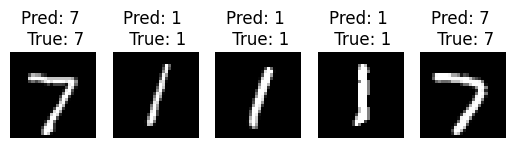

Accuracy on test set: 99.72%


In [7]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

# Get a batch of test data
images, labels = next(iter(test_loader))  # Get a batch of images
outputs = model(images)
print(images.shape)
# Get predicted class indices
_, predicted = torch.max(outputs, 1)

# Plot the first 5 images in the batch with their predicted and true labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")  # squeeze to remove unnecessary dimension
    plt.title(f"Pred: {(predicted[i].item())*6+1} \n True: {(labels[i].item())*6+1}")
    plt.axis('off')

plt.show()

# Compute accuracy on the test dataset
correct = 0
total = 0
with torch.no_grad():  # No need to track gradients for evaluation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100  # Accuracy as percentage
print(f"Accuracy on test set: {accuracy:.2f}%")



We can now check the one that the model struggled with

In [91]:
images[0].shape

torch.Size([1, 28, 28])

In [ ]:
outputs = model(images[0])
outputs[0][0].item()

1.4795042968529515e-10

tensor([[1.4795e-10, 1.0000e+00],
        [9.9985e-01, 1.4780e-04],
        [9.9985e-01, 1.5317e-04],
        ...,
        [9.9995e-01, 5.2858e-05],
        [1.8353e-10, 1.0000e+00],
        [1.0000e+00, 3.8400e-06]])
index 237
True label:  tensor(7)
Pred label:  tensor(1)


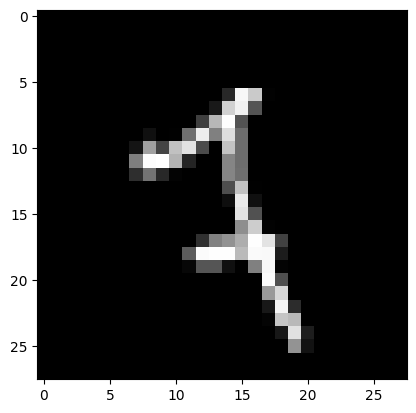

tensor([[1.4795e-10, 1.0000e+00],
        [9.9985e-01, 1.4780e-04],
        [9.9985e-01, 1.5317e-04],
        ...,
        [9.9995e-01, 5.2858e-05],
        [1.8353e-10, 1.0000e+00],
        [1.0000e+00, 3.8400e-06]])
index 278
True label:  tensor(7)
Pred label:  tensor(1)


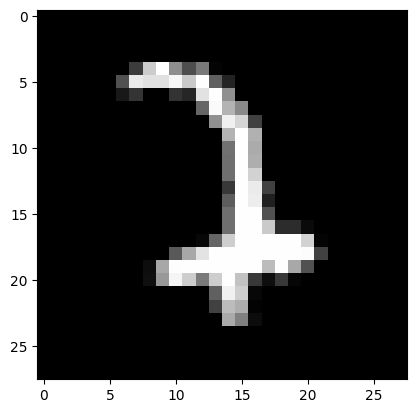

tensor([[1.4795e-10, 1.0000e+00],
        [9.9985e-01, 1.4780e-04],
        [9.9985e-01, 1.5317e-04],
        ...,
        [9.9995e-01, 5.2858e-05],
        [1.8353e-10, 1.0000e+00],
        [1.0000e+00, 3.8400e-06]])
index 286
True label:  tensor(7)
Pred label:  tensor(1)


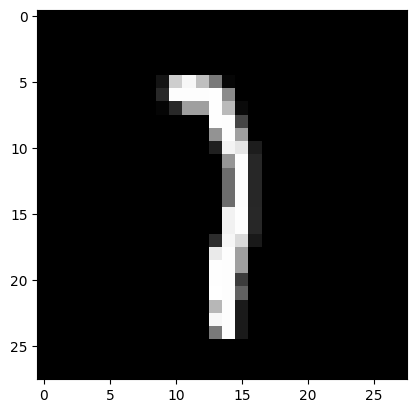

tensor([[1.4795e-10, 1.0000e+00],
        [9.9985e-01, 1.4780e-04],
        [9.9985e-01, 1.5317e-04],
        ...,
        [9.9995e-01, 5.2858e-05],
        [1.8353e-10, 1.0000e+00],
        [1.0000e+00, 3.8400e-06]])
index 329
True label:  tensor(7)
Pred label:  tensor(1)


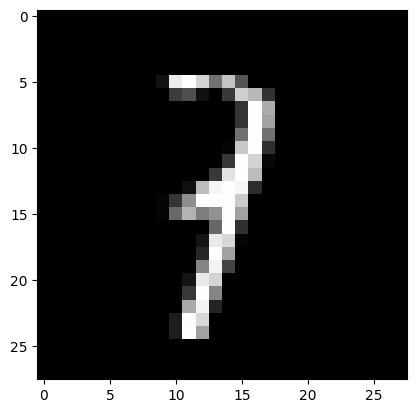

tensor([[1.4795e-10, 1.0000e+00],
        [9.9985e-01, 1.4780e-04],
        [9.9985e-01, 1.5317e-04],
        ...,
        [9.9995e-01, 5.2858e-05],
        [1.8353e-10, 1.0000e+00],
        [1.0000e+00, 3.8400e-06]])
index 1410
True label:  tensor(1)
Pred label:  tensor(7)


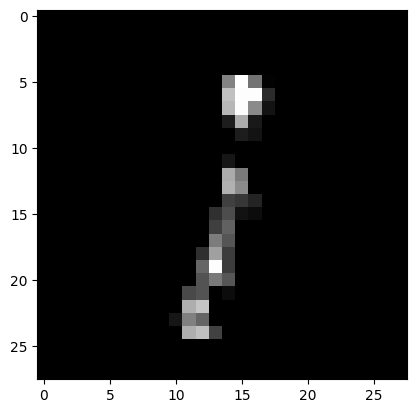

tensor([[1.4795e-10, 1.0000e+00],
        [9.9985e-01, 1.4780e-04],
        [9.9985e-01, 1.5317e-04],
        ...,
        [9.9995e-01, 5.2858e-05],
        [1.8353e-10, 1.0000e+00],
        [1.0000e+00, 3.8400e-06]])
index 1411
True label:  tensor(7)
Pred label:  tensor(1)


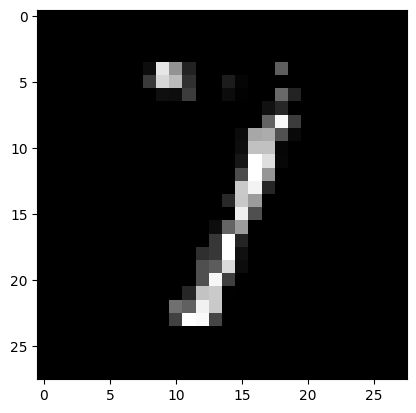

In [ ]:
test_all = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
wrong_label =[]
with torch.no_grad():  # No need to track gradients for evaluation
    for images, labels in test_all:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(images)):
            if (predicted [i] != labels[i]) : 
                print('index', i)
                print('True label: ', labels[i]*6+1)
                print('Pred label: ', predicted[i]*6+1)
                wrong_label.append(i)
                plt.imshow(images[i].squeeze(), cmap="gray")
            
                plt.show()

## SHAP

### Shapley value 

In game theory, **Shapley Values represent the contribution $\phi_i$ of a player $i$ within a coalition $S$ by comparing the outcomes of scenarios where the player is present  $v(S \cup \{i\})$ versus absent $v(S)$**.
\begin{equation}
  \phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! \, (|N| - |S| - 1)!}{|N|!} \, \left[ v(S \cup \{i\}) - v(S) \right]
\end{equation}

Applied to XAI, this involves computing the difference in model outputs between these scenarios, but ends up being difficulte to compute in most real applications due to the high dimensionality of the data.


In [9]:
pow(2,28*28)

101745825697019260773923519755878567461315282017759829107608914364075275235254395622580447400994175578963163918967182013639660669771108475957692810857098847138903161308502419410142185759152435680068435915159402496058513611411689167650816

This is the number of coalition we would have to compute to assess the contribution of each pixel. 

In a naive way, let's approximate the SV by taking a random amount of contribution.

In [72]:
import random
from itertools import combinations
import math


def power_set(iterable, num_sets=None):
    if num_sets == None :
        """Generate all subsets of a given iterable, excluding full set."""
        s = list(iterable)
        return [set(comb) for r in range(1, len(s)) for comb in combinations(s, r)]

    else : 
        """Generate a fixed number of random subsets of a given iterable, excluding the full set."""

        s = list(iterable)
        subsets = set()
        
        # Keep generating random subsets until we have the desired number
        while len(subsets) < num_sets:
            r = random.randint(0, len(s)-1)  # Random size of subset (excluding the full set)
            random_subset = set(random.sample(s, r))
            
            if random_subset not in subsets:
                subsets.add(frozenset(random_subset))  # Use frozenset to avoid duplicates
        
    return [set(subset) for subset in subsets]

sets = power_set(set(range(16)), 1000)


In [74]:
# Function to display the segmented image with 10 parts
def display_segmented_image(image, activation_mask):
    """
    Display the segmented image where each segment is activated/deactivated based on the mask.
    
    Parameters:
        image: numpy array of shape (28, 28) representing the grayscale image
        activation_mask: numpy array of shape (10,) where each element is 1 (active) or 0 (inactive)
    """
    # Create a copy of the image to modify based on activation
    modified_image = np.zeros_like(image)
    
    # Calculate the grid size (2 rows, 5 columns for 10 parts)
    row_size = 7 
    col_size = 7  
    
    for i in range(4):  # 2 rows
        for j in range(4):  # 5 columns
            # Check if the segment is activated (1) or deactivated (0)
            part_index = i * 4 + j
            if activation_mask[part_index] == 1:
                # Activate the segment, keeping original values from the image
                modified_image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size] = \
                    image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size]
    return modified_image


In [ ]:
def create_binary_list(indices, size =16):
    binary_list = [0] * size  # Initialize all to 0
    for i in indices:
        if 0 <= i < size:  # Ensure index is within range
            binary_list[i] = 1
    return binary_list


[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

In [77]:
image = images[0].squeeze()


Activation Mask:  [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


/tmp/ipykernel_2619/143947436.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  modified_image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size] = \


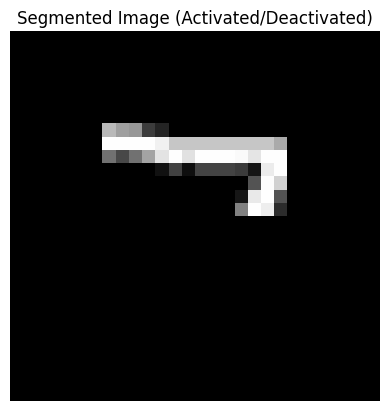

In [78]:
# Example image: Random 28x28 grayscale image (for demonstration)
image = images[0].squeeze()
set_idx = 49
# Display the original and segmented image
print("Activation Mask: ", create_binary_list(sets[set_idx]))
modified_image = display_segmented_image(image, create_binary_list(sets[set_idx]))
plt.imshow(modified_image, cmap='gray')
plt.title('Segmented Image (Activated/Deactivated)')
plt.axis('off')
plt.show()

In [96]:
model(torch.tensor(image_activated))[0][0].item()

0.06628911197185516

In [89]:
image_activated = np.expand_dims(image_activated, axis=0)
image_activated.shape


(1, 1, 28, 28)

In [98]:
n = 16
shapley_vals = np.zeros(n)
all_values = []
all_subset = []
subsets = power_set(set(range(n)), 1000)

for i in range(n):
    
    for subset in subsets:
        if i in subset: 
            subset_with_i = list(subset) 
            subset_without_i = subset
            subset_without_i.discard(i) 
        else : 
            subset_without_i = list(subset) 
            subset_with_i = list(subset) + [i]

        weight = (math.factorial(len(subset_without_i)) * math.factorial(n - len(subset_without_i) - 1)) / math.factorial(n)


        image_activated = display_segmented_image(image, create_binary_list(subset_with_i))
        image_deactivated = display_segmented_image(image, create_binary_list(subset_without_i))
        image_activated = np.expand_dims(image_activated, axis=0)
        image_deactivated = np.expand_dims(image_deactivated, axis=0)

        v_S_i = model(torch.tensor(np.expand_dims(image_activated, axis=0)))[0][0].item()
        v_S = model(torch.tensor(np.expand_dims(image_deactivated, axis=0)))[0][0].item()

        
        all_values.append(v_S_i)
        all_subset.append(len(subset))

        # Compute marginal contribution
        shapley_vals[i] += weight * (v_S_i - v_S)
    print(f"{i}th x done")



/tmp/ipykernel_2619/143947436.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  modified_image[i*row_size:(i+1)*row_size, j*col_size:(j+1)*col_size] = \


0th x done
1th x done
2th x done
3th x done
4th x done
5th x done
6th x done
7th x done
8th x done
9th x done
10th x done
11th x done
12th x done
13th x done
14th x done
15th x done


[]

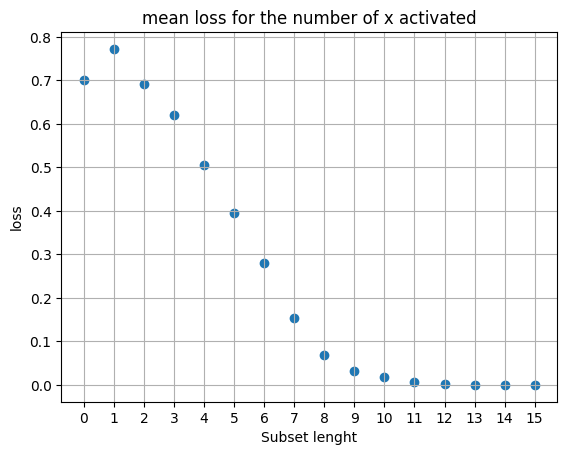

In [102]:
length_to_sum = {}  # Stores sum of values for each length
length_to_count = {}  # Stores count of occurrences for each length

# Group sums and counts by length
for length, value in zip(all_subset, all_values):
    if length in length_to_sum:
        length_to_sum[length] += value
        length_to_count[length] += 1
    else:
        length_to_sum[length] = value
        length_to_count[length] = 1

# Compute mean for each length
mean_by_length = {length: length_to_sum[length] / length_to_count[length] for length in length_to_sum}

plt.scatter(mean_by_length.keys(),mean_by_length.values())
plt.xlabel('Subset lenght')
plt.ylabel('loss')
plt.title('mean loss for the number of x activated')
plt.xticks(range(0,18))
plt.grid()
plt.plot()

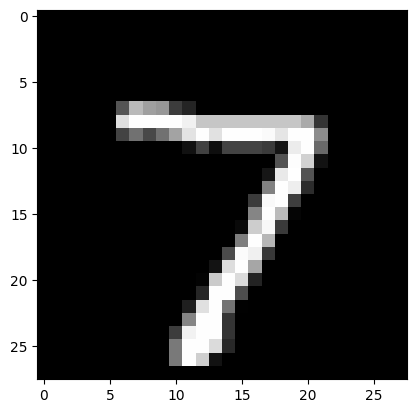

In [ ]:
plt.imshow(image, cmap='gray')


### SHAP for applying Shapley Value


Indeed, first, the number of Shapley Values to compute grows exponentially with the number of features, resulting in high computational complexity for models with large feature spaces ($N$ features, $2^N$ coalitions).

Second, defining a baseline to represent the "absence" of a feature is critical but can vary significantly depending on the data and domain, affecting the interpretability of the results.

SHAP values are shapley values fo a conditional expectation function of the original model.

Kernel SHAP is a model-agnostic approach that uses a weighted linear regression framework to approximate Shapley Values by sampling feature subsets. 

In [ ]:
import shap



In [88]:
shap_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)


batch = next(iter(test_all))
images, _ = batch

background = images[:100]
test_images = images[wrong_label]


In [89]:
background.shape

torch.Size([100, 1, 28, 28])

In [90]:
test_images.shape

torch.Size([6, 1, 28, 28])

In [91]:


e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [92]:
shap_values.shape

(6, 1, 28, 28, 2)

In [93]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

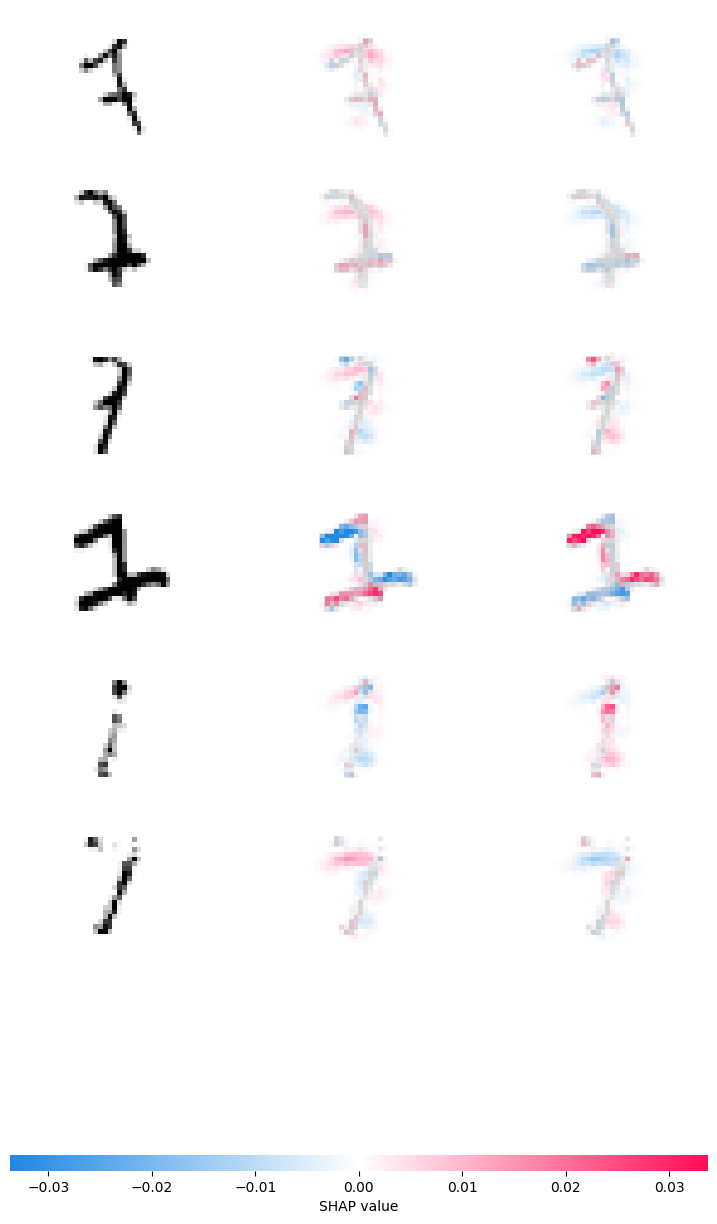

In [94]:
shap.image_plot(shap_numpy, -test_numpy)

Remark : 

- In this example we are using grayscale, so we are only computing the gradient of each pixel on one dimension. In case the input is several dimension, the 

- One sanity test to run is to test to check the completeness. The completness property is imply by the sensitivity $\sum_{i=1}^{n}IntegratedGrads(x)=F(x) - F(x')$